In [1]:
# Dependencies
import tweepy
import json
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
# Target Hashtags
target_tags = ("#Nintendo", "#PS4", "#X360", "#Wii", "#PS3", "#DS")
time_between_tweets = []

# Loop through each hashtag
for tag in target_tags:
    
    # Create array to record all date-times of tweets
    tweet_times = []

    # Get 100 tweets on targetted tag
    public_tweets = api.search(tag, rpp=100)
    print(tag)

    # Loop through all tweets
    for tweet in public_tweets["statuses"]:

        # Store all tweet times into the array
        tweet_times.append(tweet["created_at"])
    
    # Convert all tweet times into datetime objects
    tweet_time_objects = []

    # Add each datetime object into the array
    for x in range(len(tweet_times)):
        tweet_datetime = datetime.strptime(tweet_times[x], "%a %b %d %H:%M:%S %z %Y")
        tweet_time_objects.append(tweet_datetime)

    # Calculate the time between tweets
    time_in_between = []

    # Calculate the time in between each tweet
    for x in range(len(tweet_time_objects)-1):
        secs_apart = ((tweet_time_objects[x] - tweet_time_objects[x+1]).seconds) 
        time_in_between.append(secs_apart)

    # Seconds Between Tweets
    print(f"Avg. Seconds Between Tweets: {np.mean(time_in_between)}")
    print()

#Nintendo
Avg. Seconds Between Tweets: 12.214285714285714

#PS4
Avg. Seconds Between Tweets: 2.5714285714285716

#X360
Avg. Seconds Between Tweets: 11029.357142857143

#Wii
Avg. Seconds Between Tweets: 1021.3571428571429

#PS3
Avg. Seconds Between Tweets: 205.42857142857142

#DS
Avg. Seconds Between Tweets: 128.07142857142858



In [3]:
# Target Search Term
target_terms = ("#Nintendo", "#PS4", "#Xbone", "#Wii", "#PS3", "#DS")


# "Real Person" Filters
min_tweets = 5
max_tweets = 10000
max_followers = 2500
max_following = 2500
lang = "en"

# List to hold results
results_list = []

# Loop through all target users
for target in target_terms:

    # Variable for holding the oldest tweet
    oldest_tweet = None

    # Variables for holding sentiments
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []

    # Loop through 5 times
    for x in range(5):

        # Run search around each tweet
        public_tweets = api.search(
            target, count=100, result_type="recent", max_id=oldest_tweet)

        # Loop through all tweets
        for tweet in public_tweets["statuses"]:

            # Use filters to check if user meets conditions
            if (tweet["user"]["followers_count"] < max_followers
                and tweet["user"]["statuses_count"] > min_tweets
                and tweet["user"]["statuses_count"] < max_tweets
                and tweet["user"]["friends_count"] < max_following
                and tweet["user"]["lang"] == lang):

                # Run Vader Analysis on each tweet
                results = analyzer.polarity_scores(tweet["text"])
                compound = results["compound"]
                pos = results["pos"]
                neu = results["neu"]
                neg = results["neg"]

                # Add each value to the appropriate list
                compound_list.append(compound)
                positive_list.append(pos)
                negative_list.append(neg)
                neutral_list.append(neu)
                
            # Set the new oldest_tweet value
            oldest_tweet = tweet["id"] - 1

    # Store the Average Sentiments
    sentiment = {
        "User": target,
        "Compound": np.mean(compound_list),
        "Positive": np.mean(positive_list),
        "Neutral": np.mean(negative_list),
        "Negative": np.mean(neutral_list),
        "Tweet Count": len(compound_list)
    }

    # Print the Sentiments
    print(sentiment)
    print()
    
    # Append  results to 'results_list'
    results_list.append(sentiment)

{'User': '#Nintendo', 'Compound': 0.14830449438202248, 'Positive': 0.07591760299625468, 'Neutral': 0.023314606741573034, 'Negative': 0.9007565543071161, 'Tweet Count': 267}

{'User': '#PS4', 'Compound': 0.09617183098591549, 'Positive': 0.051211267605633805, 'Neutral': 0.01495774647887324, 'Negative': 0.9338169014084508, 'Tweet Count': 71}

{'User': '#Xbone', 'Compound': 0.18329795918367348, 'Positive': 0.09987755102040817, 'Neutral': 0.02436734693877551, 'Negative': 0.8757551020408163, 'Tweet Count': 98}

{'User': '#Wii', 'Compound': 0.1429863945578231, 'Positive': 0.07342176870748299, 'Neutral': 0.023034013605442178, 'Negative': 0.9035510204081633, 'Tweet Count': 147}

{'User': '#PS3', 'Compound': 0.11139759036144577, 'Positive': 0.07244578313253011, 'Neutral': 0.03207228915662651, 'Negative': 0.8954939759036146, 'Tweet Count': 83}

{'User': '#DS', 'Compound': 0.20322474226804124, 'Positive': 0.08610309278350514, 'Neutral': 0.024350515463917526, 'Negative': 0.8894948453608248, 'Tweet 

In [4]:
VG_df = pd.DataFrame(results_list).round(3)
VG_df

,Compound,Negative,Neutral,Positive,Tweet Count,User
0,0.148,0.901,0.023,0.076,267,#Nintendo
1,0.096,0.934,0.015,0.051,71,#PS4
2,0.183,0.876,0.024,0.100,98,#Xbone
3,0.143,0.904,0.023,0.073,147,#Wii
4,0.111,0.895,0.032,0.072,83,#PS3
5,0.203,0.889,0.024,0.086,97,#DS


AttributeError: 'BarContainer' object has no attribute 'annotate'

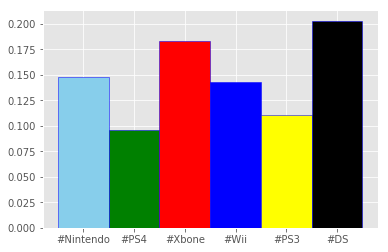

In [9]:
#Overall Gaming Sentiment Bar Chart
colors = ['skyblue','green','red', 'blue', 'yellow', 'black']
y_vals = VG_df["Compound"]
x_vals = VG_df["User"]
sentiment_chart = plt.bar(x_vals, y_vals, color=colors, align ='center',width=1.0, edgecolor ='b')


#Bar value labels 
ax=sentiment_chart
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
#Other properties of the chart
now = datetime.now()
now = now.strftime("%Y-%m-%d %H:%M")
plt.title(f"Overall Video Games Sentiment based on twitter ({now})") 
plt.ylabel("Tweet Polarity")
plt.xlabel("Gaming Hastag")
plt.grid(False)
plt.show()